In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
from DE_library import simulate_ODE, simulate_trajectories
import matplotlib.pyplot as plt
from example_utils import reject_outliers, initial_conditions, plot_phase_portrait, plot_phase_portrait, find_nn, circle

from MARBLE import utils, geometry, net, plotting, postprocessing, compare_attractors

In [2]:
def simulate_system(mu, X0, t):
    p, v = simulate_trajectories('vanderpol', X0, t, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = reject_outliers(p_, v_)
        pos.append(p_[ind])
        vel.append(v_[ind])
        
    return pos, vel

def parabola(X, Y, alpha=0.05):
    Z = -(alpha*X)**2 -(alpha*Y)**2
    
    return np.column_stack([X.flatten(), Y.flatten(), Z.flatten()])

# For initial conditions, sample a rectangle uniformly

In [3]:
t0, t1, dt = 0, 10, 0.2
t = np.arange(t0, t1, dt)
n = 5
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [4]:
X0_range = initial_conditions(n, 1, area,seed=11)[0]
pos, vel = simulate_system(0.5, X0_range, t)
    
#embed on parabola
for i, (p, v) in enumerate(zip(pos, vel)):
    end_point = p + v
    new_endpoint = parabola(end_point[:,0], end_point[:,1])
    pos[i] = parabola(p[:,0], p[:,1])
    vel[i] = new_endpoint - pos[i]

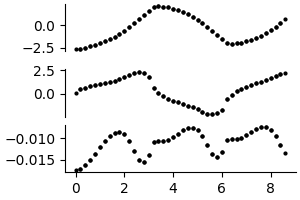

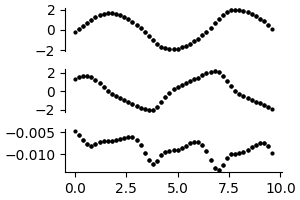

In [5]:
plotting.time_series(t, list(pos[0].T), style='.', figsize=(3,2), ms=4)
plt.savefig('time_series.svg')
plotting.time_series(t, list(pos[1].T), style='.', figsize=(3,2), ms=4)
plt.savefig('time_series_2.svg')

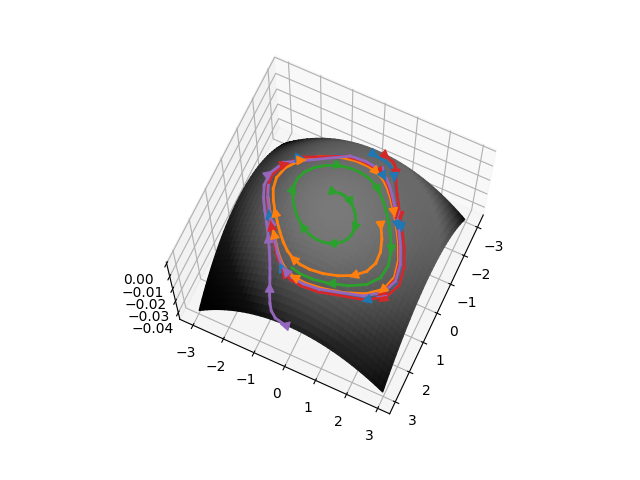

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

from matplotlib.colors import LightSource

X, Y = np.mgrid[-3.:3.:0.05, -3.:3.:0.05]
xyz = np.array(parabola(X.flatten(), Y.flatten()))
ls = LightSource(azdeg=30,altdeg=30)
rgb = ls.shade(xyz[:,2].reshape(X.shape)-0.1, plt.cm.gray)


ax.plot_surface(X, Y, xyz[:,2].reshape(X.shape),
                color='gray', 
                shade=True,
                lightsource=ls,
                facecolors=rgb,
                zorder=0
               )

ax = plot_phase_portrait(pos, vel, ax=ax,style='-', lw=2,
                         node_feature=[[i]*len(p) for i, p in enumerate(pos)])
ax = plot_phase_portrait(pos, vel, ax=ax,style='>', scale=10, lw=15, spacing=5,
                         node_feature=[[i]*len(p) for i, p in enumerate(pos)])

ax.view_init(elev=70, azim=25)
#plt.savefig('./outputs/parabolas.svg')

In [8]:
pos_concat, vel_concat = np.vstack(pos), np.vstack(vel)
data = utils.construct_dataset(pos_concat, features=vel_concat, graph_type='cknn', k=15, stop_crit=0.03, vector=False)

---- Embedding dimension: 3
---- Signal dimension: 3

Vector computations are disabled

---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


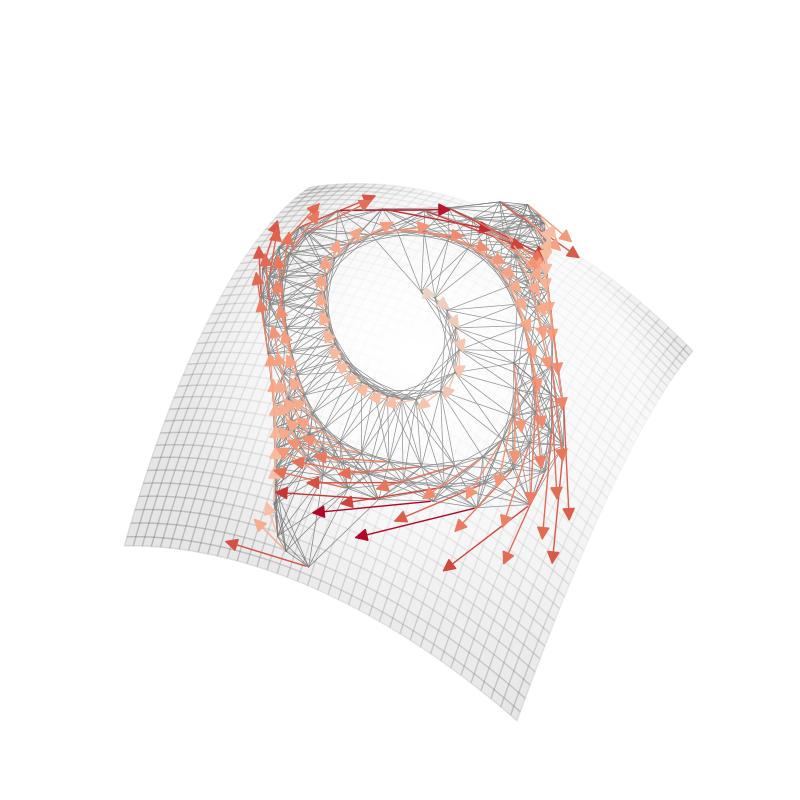

In [9]:
ax = plotting.fields(data, col=1, alpha=1, width=20, scale=2, view=[70,25])

ax[0].plot_surface(X, Y, xyz[:,2].reshape(X.shape)-0.01,
                color='white', 
                alpha=0.1,
                shade=False,
                lightsource=ls,
                facecolors=rgb,
                zorder=0
               )
#plt.savefig('./outputs/parabola_graph.svg')

In [11]:
par = {'epochs': 75, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 4,
       'inner_product_features': True,
      }

model = net(data, par=par)
model.run_training(data)


---- Settings: 

epochs : 75
order : 2
hidden_channels : 32
out_channels : 4
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  698

---- Training network ...

Epoch: 1, Training loss: 1.3771, Validation loss: 1.3900, lr: 0.0100 *
Epoch: 2, Training loss: 1.3837, Validation loss: 1.3672, lr: 0.0100 *
Epoch: 3, Training loss: 1.3828, Validation loss: 1.3969, lr: 0.0100
Epoch: 4, Training loss: 1.3897, Validation loss: 1.4050, lr: 0.0100
Epoch: 5, Training loss: 1.3835, Validation loss: 1.3923, lr: 0.0100
Epoch: 6, Training loss: 1.3763, Validation loss: 1.3931, lr: 0.0100
Epoch: 7, Training loss: 1.3838, Validation loss: 1.3850, lr: 0.0100
Epoch: 8, Training loss: 1.3795, Valid

Performed umap embedding on embedded results.


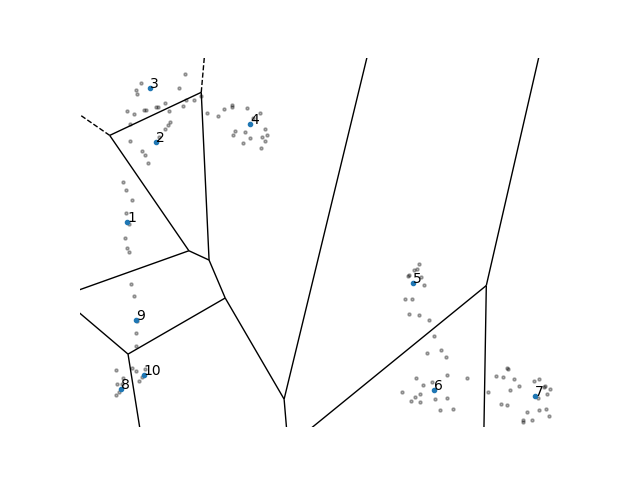

In [12]:
data = model.evaluate(data)
data = postprocessing(data, n_clusters=10)
plotting.embedding(data)
plt.savefig('embedding.svg')